# NN Regression with Keras

- **Created by Andrés Segura Tinoco**
- **Created on Oct 4, 2019**

In [1]:
# General Libraries
import pandas as pd
import numpy as np
import csv
import time
import datetime
from platform import python_version
from datetime import datetime
from datetime import timedelta
from pathlib import Path
from math import sqrt, fabs
from IPython.display import Image

In [2]:
# ML Libraries - Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from scipy.interpolate import interp1d

In [3]:
# ML Libraries - Keras
import keras
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import *
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [4]:
# Load Plot libraries
import matplotlib.pyplot as plt

In [5]:
# Framework version
tf.logging.set_verbosity(tf.logging.ERROR)
print('Python version:', python_version(), ', Keras version:', keras.__version__, ", TensorFlow version: " + tf.__version__)

Python version: 3.6.8 , Keras version: 2.2.5 , TensorFlow version: 1.13.2


## 1. Load and show data

The first thing we do is load the input dataset.

In [6]:
# Read raw data
dataURL = "../data/dataset-single.csv"
raw_data = pd.read_csv(dataURL)

In [7]:
# Dataframe rows and columns
raw_data.shape

(2254, 16)

In [8]:
# Show default data types
raw_data.dtypes

WellID              int64
Date               object
MethodID            int64
CHP               float64
THP               float64
Temp              float64
Choke             float64
Qinj              float64
Bo                float64
Zed               float64
SpgO              float64
SpgGP             float64
Rel_Oper_Press    float64
Rel_Crit_Press    float64
WC                float64
Test_Oil          float64
dtype: object

In [9]:
# Preview the first 5 lines of the loaded data
raw_data.head()

,WellID,Date,MethodID,CHP,THP,Temp,Choke,Qinj,Bo,Zed,SpgO,SpgGP,Rel_Oper_Press,Rel_Crit_Press,WC,Test_Oil
0,84,7/23/2012,9008,305.930240,226.150470,96.87778,1.725,0.0,1.114856,0.972937,0.92303,0.799,0.739222,0.530322,0.366667,10945.72
1,84,7/24/2012,9008,306.275013,226.743155,97.46500,1.725,0.0,1.115611,0.973062,0.92303,0.799,0.740325,0.530345,0.323958,NaN
2,84,7/25/2012,9008,306.347978,227.299286,97.93182,1.725,0.0,1.116182,0.973176,0.92303,0.799,0.741964,0.530387,0.281250,NaN
3,84,7/26/2012,9008,306.309006,227.826828,99.60455,1.725,0.0,1.118186,0.973606,0.92303,0.799,0.743781,0.530576,0.325000,NaN
4,84,7/27/2012,9008,306.369882,228.283965,100.27730,1.725,0.0,1.119005,0.973771,0.92303,0.799,0.745125,0.530641,0.335000,NaN


## 2. Prepare the data to Learn

Now the data is prepared for the learning of the NN model based on the result of the Data Profiling.

In [10]:
# Create new dataframe
new_data = raw_data.copy(deep=True)

In [11]:
# List of variables to eliminate based on the Data Profiling
delete_cols = ["WellID", "SpgO", "SpgGP"]
delete_cols

['WellID', 'SpgO', 'SpgGP']

In [12]:
# Remove non-relevant columns
new_data.drop(columns=delete_cols, axis=1, inplace=True)

In [13]:
# Data quality: convert date to normalized integer
date_var = "Date"
date_fields = [date_var]

for field in date_fields:
    if field in new_data:
        new_data[field] = pd.to_numeric(pd.to_datetime(new_data[field]))
        if field == date_var:
            date_max = new_data[field].max()
        new_data[field] = (new_data[field] / new_data[field].max())

In [14]:
# Set deadlines values
deadline_list = ["2018-09-01", "2018-10-01"]
deadline = pd.to_numeric(pd.to_datetime(deadline_list))
date_val = deadline[0] / date_max
date_test = deadline[1] / date_max
print("Date_val:", date_val, ", date_test:", date_test)

Date_val: 0.9965799506615833 , date_test: 0.9982619421394932


#### Showing new dataframe stats

In [15]:
# Show default data types
new_data.dtypes

Date              float64
MethodID            int64
CHP               float64
THP               float64
Temp              float64
Choke             float64
Qinj              float64
Bo                float64
Zed               float64
Rel_Oper_Press    float64
Rel_Crit_Press    float64
WC                float64
Test_Oil          float64
dtype: object

In [16]:
# Preview the first 5 lines of the processed data
new_data.head()

,Date,MethodID,CHP,THP,Temp,Choke,Qinj,Bo,Zed,Rel_Oper_Press,Rel_Crit_Press,WC,Test_Oil
0,0.871496,9008,305.930240,226.150470,96.87778,1.725,0.0,1.114856,0.972937,0.739222,0.530322,0.366667,10945.72
1,0.871552,9008,306.275013,226.743155,97.46500,1.725,0.0,1.115611,0.973062,0.740325,0.530345,0.323958,NaN
2,0.871608,9008,306.347978,227.299286,97.93182,1.725,0.0,1.116182,0.973176,0.741964,0.530387,0.281250,NaN
3,0.871664,9008,306.309006,227.826828,99.60455,1.725,0.0,1.118186,0.973606,0.743781,0.530576,0.325000,NaN
4,0.871720,9008,306.369882,228.283965,100.27730,1.725,0.0,1.119005,0.973771,0.745125,0.530641,0.335000,NaN


## 3. Create Train/Validation/Test datasets

Now the input dataset is separated into 3 new datasets: training (history minus 2 months), validation (last month) and testing (current month).

In [17]:
# Function that interpolates the real value (oil well test)
def get_estimated_value(kind_method=''):
    ### kind: '', cubic', 'nearest', 'previous', 'next' ###
    
    temp_data = new_data[["Test_Oil"]].dropna(thresh=1)
    x = list(temp_data.index)
    y = list(temp_data.Test_Oil)
    x_min = min(x)
    x_max = max(x)
    x_new = np.linspace(x_min, x_max, num=(x_max-x_min)+1, endpoint=True)
    
    if kind_method == '':
        f = interp1d(x, y)
    else:
        f = interp1d(x, y, kind=kind_method)
    
    y_new = f(x_new)
    return y_new

In [18]:
# Create pretty x axis labels
def get_x_labels(all_labels):
    x_labels = []
    for ix in range(len(all_labels)):
        if ix % 100 == 0:
            x_labels.append(all_labels[ix])
        else:
            x_labels.append('')
    return x_labels

In [19]:
# Find deadlines indexes
split_val = int(new_data[new_data[date_var] == date_val].index[0])
split_test = int(new_data[new_data[date_var] == date_test].index[0])
print("Split validation index:", split_val, ", split test index:", split_test)

Split validation index: 2192 , split test index: 2222


In [20]:
# Split into input (X) and output (Y) vectors
dataset = new_data.values
nCols = dataset.shape[1] - 1
x_data = dataset[:, 0:nCols]
y_data = dataset[:, nCols]
y_estimated = get_estimated_value()
xs = range(len(x_data))
xticks = get_x_labels(raw_data.Date)

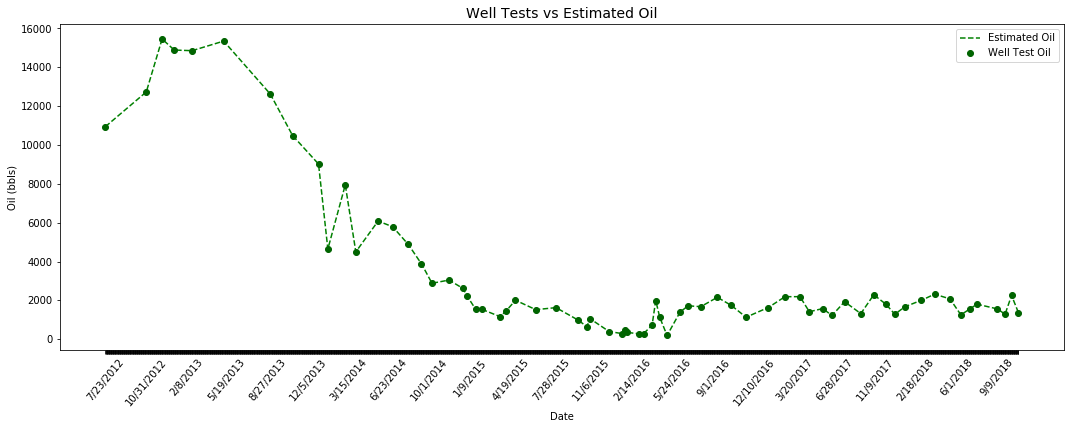

In [21]:
# Plot chart
plt.figure(figsize = (18, 6))
plt.plot(xs, y_estimated, '--', color='green')
plt.plot(xs, y_data, 'o', color='darkgreen')
plt.legend(['Estimated Oil', 'Well Test Oil'], loc='best')
plt.title('Well Tests vs Estimated Oil', fontsize = 14)
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Oil (bbls)', fontsize = 10)
plt.xticks(xs, xticks, fontsize = 10, rotation = 50)
plt.show()

In [22]:
# Split into train-validation and test datasets
test_perc = (len(x_data) - split_test) / len(x_data)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_estimated, test_size=test_perc, shuffle=False)

# Split into train and validation datasets
val_perc = (len(x_train) - split_val) / len(x_train)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_perc, shuffle=False)
print("Train rows:", len(x_train), ", Validation rows:", len(x_val), ", Test rows:", len(x_test))

Train rows: 2192 , Validation rows: 30 , Test rows: 32


## 4. Train Model

In **machine learning**, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are learned.

The hyperparameters that we will use next were experimentally selected. Ideally, select them with a more robust method such as gradient descent.

In [23]:
# Set NN hyper-params
curr_n = x_data.shape[1]
curr_model = 'larger'
curr_units = 500
curr_optimizer = 'adam'
curr_loss = 'mean_squared_error'
curr_metric = 'mse'
curr_learn_rate = 0.001
curr_activate = 'LeakyReLU'
curr_epochs = 5000
curr_batch_size = 500

In [24]:
# Create a ANN model
def create_model(curr_model, n, curr_units, curr_optimizer, curr_loss, curr_metric, curr_learn_rate, curr_activate):
    model = Sequential()

    # define model
    if curr_model == "baseline":

        # Create model
        model.add(Dense(curr_units, input_dim=n, kernel_initializer='normal', activation='relu')) #leaky relu
        model.add(Dense(1, kernel_initializer='normal'))

    elif curr_model == "larger":

        # Input - Layer
        model.add(Dense(curr_units, input_dim=n, kernel_initializer='normal', activation='relu'))
        model.add(Dense(int(curr_units / 2), kernel_initializer='normal', activation='relu'))
        model.add(Dense(1, kernel_initializer='normal'))

    elif curr_model == "deep":

        # Input - Layer
        model.add(Dense(curr_units, input_dim=n, kernel_initializer='normal', activation='relu'))

        # Hidden - Layers
        model.add(Dropout(0.3, noise_shape=None, seed=None))
        model.add(Dense(int(curr_units / 2), kernel_initializer='normal', activation = "relu"))
        model.add(Dropout(0.2, noise_shape=None, seed=None))
        model.add(Dense(int(curr_units / 2), kernel_initializer='normal', activation = "relu"))

        # Hidden - Layers
        model.add(Dense(1, kernel_initializer='normal'))

    elif curr_model == "wider":

        # Create model
        model.add(Dense(curr_units, input_dim=n, kernel_initializer='normal', activation=curr_activate))
        model.add(Dense(1, kernel_initializer='normal'))

    elif curr_model == "lstm":

        # Create model
        model = Sequential()

    # Show model summary
    print(model.summary())

    # Compile model
    if curr_optimizer == "adam":
        opAdam = Adam(lr=curr_learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        model.compile(loss=curr_loss, optimizer=opAdam, metrics=[curr_metric])

    # Return model
    return model

In [25]:
# Create the model
model = create_model(curr_model, curr_n, curr_units, curr_optimizer, curr_loss, curr_metric, curr_learn_rate, curr_activate)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               6500      
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 251       
Total params: 132,001
Trainable params: 132,001
Non-trainable params: 0
_________________________________________________________________
None


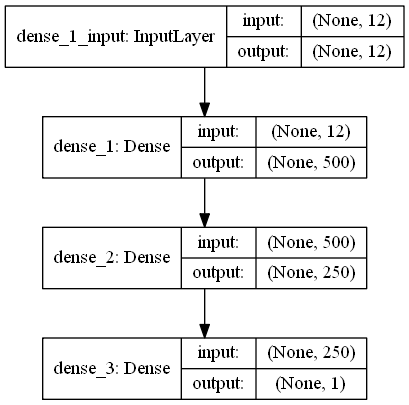

In [26]:
# Plot Keras model structure
plot_model(model, show_shapes=True, show_layer_names=True)

In [27]:
# Fit the model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=curr_epochs, batch_size=curr_batch_size, verbose=0)

## 5. Make predictions and calculate error

In [28]:
# Calculate model errors (RMSE, MAE, MAPE)
def calculate_error(y_true, y_pred, eType):
    error = 0

    # Calculations
    if eType == "RMSE":
        error = sqrt(mean_squared_error(y_true, y_pred))

    elif eType == "MAE":
        error = mean_absolute_error(y_true, y_pred)

    elif eType == "MAPE":
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        error = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Return error metric value
    return error

### Make Train predictions

In [29]:
# Make train predictions
y_predict = model.predict(x_train, batch_size=curr_batch_size)

In [30]:
# Calculate validation errors
train_rmse = calculate_error(y_train, y_predict, "RMSE")
train_mae = calculate_error(y_train, y_predict, "MAE")
train_mape = calculate_error(y_train, y_predict, "MAPE")
print('Train RMSE:', train_rmse, ', train MAE:', train_mae, ', train MAPE:', train_mape)

Train RMSE: 470.0154073883403 , train MAE: 309.189001323629 , train MAPE: 235.57290523522832


### Make Validation predictions

In [31]:
# Make validation predictions
y_predict = model.predict(x_val, batch_size=curr_batch_size)

In [32]:
# Calculate validation errors
val_rmse = calculate_error(y_val, y_predict, "RMSE")
val_mae = calculate_error(y_val, y_predict, "MAE")
val_mape = calculate_error(y_val, y_predict, "MAPE")
print('Validation RMSE:', val_rmse, ', validation MAE:', val_mae, ', validation MAPE:', val_mape)

Validation RMSE: 337.0459884678383 , validation MAE: 311.75333743489585 , validation MAPE: 21.75303694471495


### Make Test predictions

In [33]:
# Make test predictions
y_predict = model.predict(x_test, batch_size=curr_batch_size)

In [34]:
# Calculate test errors
test_rmse = calculate_error(y_test, y_predict, "RMSE")
test_mae = calculate_error(y_test, y_predict, "MAE")
test_mape = calculate_error(y_test, y_predict, "MAPE")
print('Test RMSE:', test_rmse, ', test MAE:', test_mae, ', test MAPE:', test_mape)

Test RMSE: 207.08900424924244 , test MAE: 159.05493750179517 , test MAPE: 17.521730657211915


### 6. Plot Results

In [35]:
# Make model predictions
y_predict = model.predict(x_data, batch_size=curr_batch_size)
len(y_predict)

2254

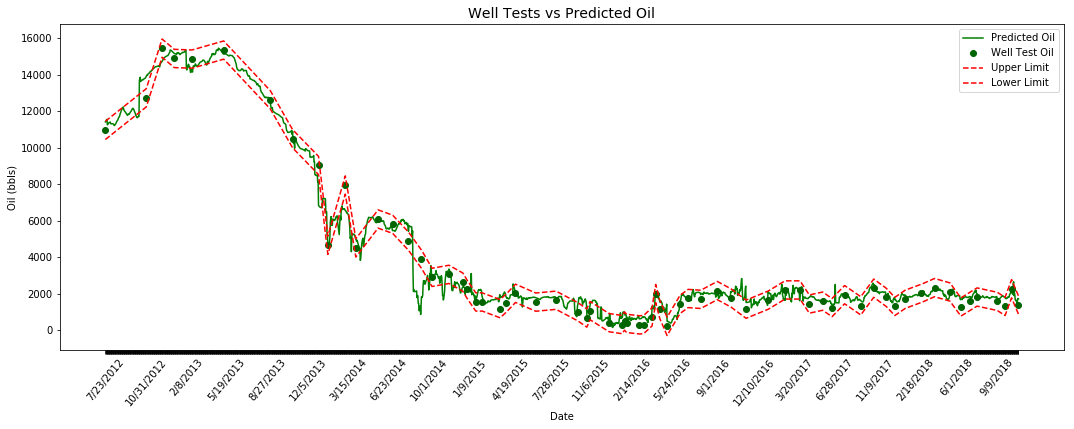

In [36]:
# Plot chart
plt.figure(figsize = (18, 6))
plt.plot(xs, y_predict, '-', color='green')
plt.plot(xs, y_data, 'o', color='darkgreen')
plt.plot(xs, y_estimated + 500, '--', color='red')
plt.plot(xs, y_estimated - 500, '--', color='red')
plt.legend(['Predicted Oil', 'Well Test Oil', 'Upper Limit', 'Lower Limit'], loc='best')
plt.title('Well Tests vs Predicted Oil', fontsize = 14)
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Oil (bbls)', fontsize = 10)
plt.xticks(xs, xticks, fontsize = 10, rotation = 50)
plt.show()

In [37]:
# Daily Difference
y_diff = [x1 - x2 for (x1, x2) in zip(y_predict, y_estimated)]
print('Avg Difference:', (sum(np.absolute(y_diff)) / len(y_diff))[0], 'bbls')

Avg Difference: 307.09207 bbls


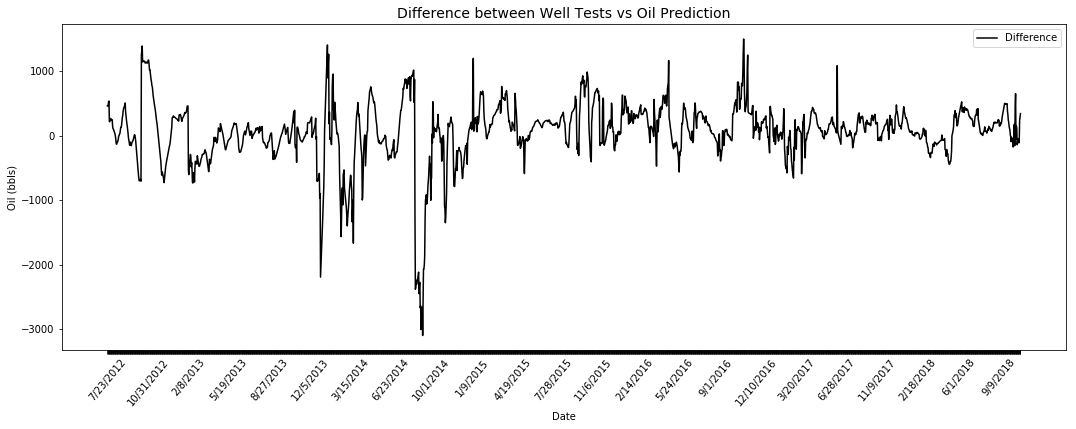

In [38]:
# Difference between Well Tests vs Oil Prediction
plt.figure(figsize = (18, 6))
plt.plot(xs, y_diff, '-', color='black')
plt.legend(['Difference'], loc='best')
plt.title('Difference between Well Tests vs Oil Prediction', fontsize = 14)
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Oil (bbls)', fontsize = 10)
plt.xticks(xs, xticks, fontsize = 10, rotation = 50)
plt.show()

<hr>
<p><a href="https://ansegura7.github.io/Keras_RegressionNN/">« Home</a></p>